In [1]:
import mne
from pathlib import Path
import matplotlib
import numpy as np
from autoreject import AutoReject
from autoreject import get_rejection_threshold
import autoreject

mne.viz.set_browser_backend("matplotlib", verbose=None)

Using matplotlib as 2D backend.


In [3]:
counter = 0

# number of set files
p = Path("/Volumes/T7/BrainLat")
set_list = list(p.glob("**/*.set"))
print(len(set_list))

my_list = [file for file in set_list if file.parent.name != "3_PD"]

266


- Visualise PSD data
- Visualise behavioral data


Some text


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-12 dB cutoff frequency: 47.50 Hz)
- Filter length: 3380 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 139 events and 1537 original time points ...
0 bad epochs dropped
No projector specified for this dataset. Please consider the method self.add_proj.


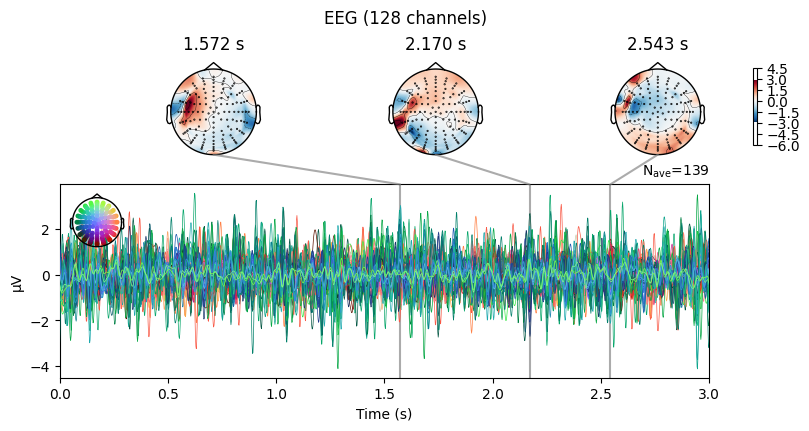

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/128 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/128 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/139 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/8 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/139 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/139 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/139 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/139 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/139 [00:00<?,       ?it/s]

KeyboardInterrupt: 

In [3]:
data_path = "/Volumes/T7/Brainlat_MNE/data"

for file in my_list:
    raw = mne.io.read_raw_eeglab(file, preload=True).set_montage("biosemi128")
    # raw.compute_psd(method="welch")
    filter_params = {
        "l_freq": 1,
        "h_freq": 45,
        "h_trans_bandwidth": 5,
        "fir_design": "firwin2",
        "phase": "zero-double",
    }
    raw_filtered = raw.filter(**filter_params)  # removedrifts
    events = mne.make_fixed_length_events(
        raw=raw_filtered, start=0, stop=None, duration=3, overlap=0, first_samp=False
    )

    # Create  Epochs object
    epochs = mne.Epochs(
        raw=raw_filtered,
        events=events,
        tmin=0,
        tmax=3,
        detrend=0,
        baseline=None,
        preload=True,
    )

    # epochs = mne.make_fixed_length_epochs(raw, duration=3, preload=True)
    # display(epochs_plot)
    epochs_plot = epochs.average().detrend().plot_joint()
    # display(psd_plot)
    ar = autoreject.AutoReject(
        n_interpolate=[
            1,
            2,
            4,
            8,
            16,
            32,
            64,
            128,
        ],
        random_state=11,
        n_jobs=-1,
        verbose=True,
    )
    ar.fit(epochs)  # fit on a few epochs to save time
    epochs_ar, reject_log = ar.transform(epochs, return_log=True)
    try:
        epochs[reject_log.bad_epochs].plot(scalings=dict(eeg=100e-6))
    except Exception as e:
        print(f"An error occurred: {e}")
    rejected_plot = reject_log.plot("horizontal", show=False)
    epochs_ar.save(f"{data_path}/epochs/{file.stem}-epo.fif")
    epo_spectrum = epochs_ar.compute_psd(method="welch", picks="eeg", exclude="bads")
    psd_plot = epo_spectrum.plot(average=True, picks="eeg", exclude="bads", show=False)
    epo_spectrum.plot_topomap(ch_type="eeg", agg_fun=np.median)
    epo_spectrum.save(f"{data_path}/psd/{file.stem}.h5", overwrite=True)

In [34]:
data_path = "/Volumes/T7/Brainlat_MNE/data"
epo_spectrum.save(f"{data_path}/psd/{file.stem}.h5")

In [28]:
epo_spectrum.save(f"~/PhD/Projects/brain-lat/data/psd/{file.stem}.h5")

In [16]:
ica = mne.preprocessing.ICA(random_state=99, n_components=60, method="picard")
ica.fit(epochs_ar)

Fitting ICA to data using 128 channels (please be patient, this may take a while)
Selecting by number: 60 components
Fitting ICA took 35.5s.


<ICA | epochs decomposition, method: picard (fit in 225 iterations on 189051 samples), 60 ICA components (128 PCA components available), channel types: eeg, no sources marked for exclusion>

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated


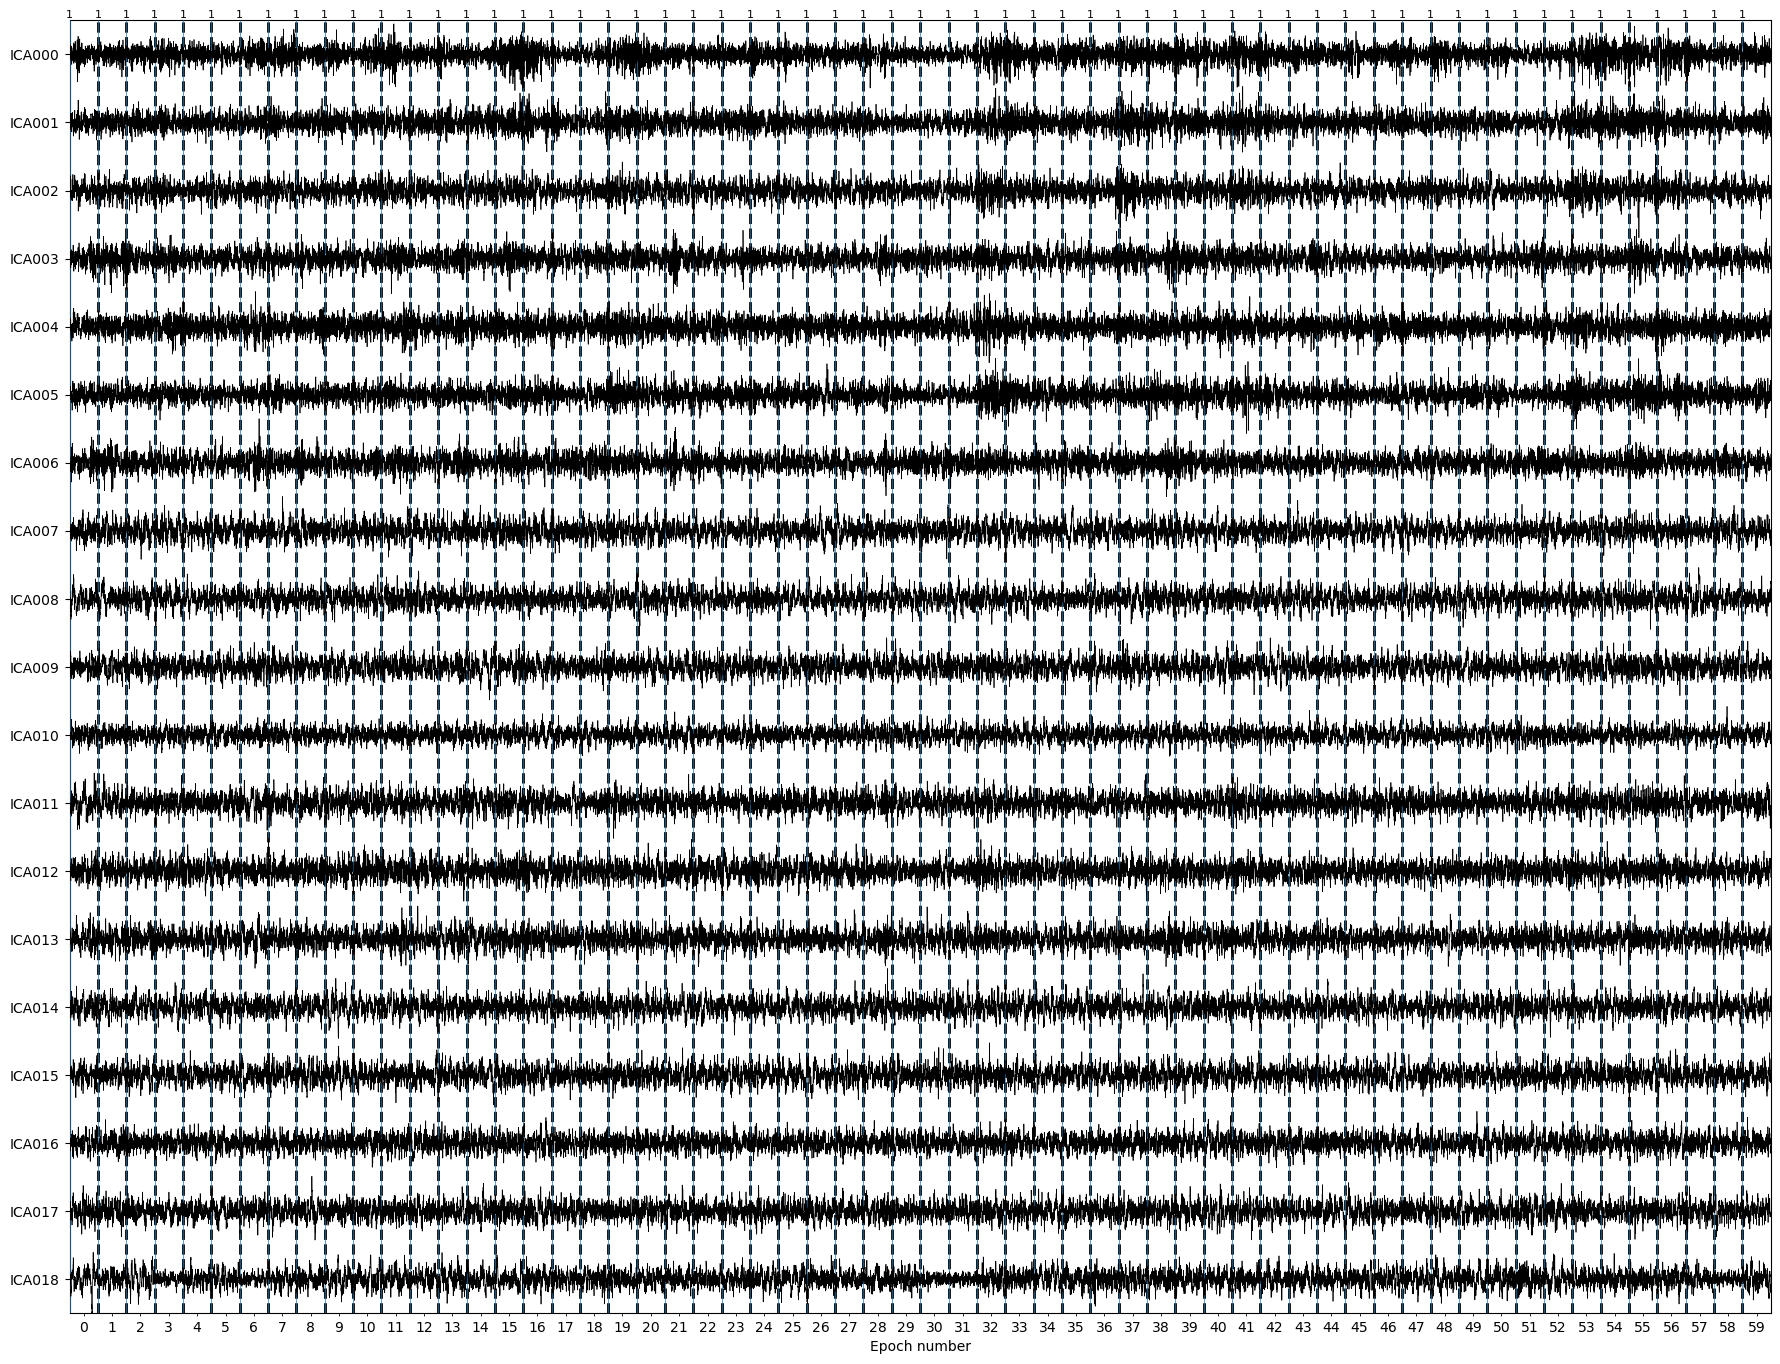

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated


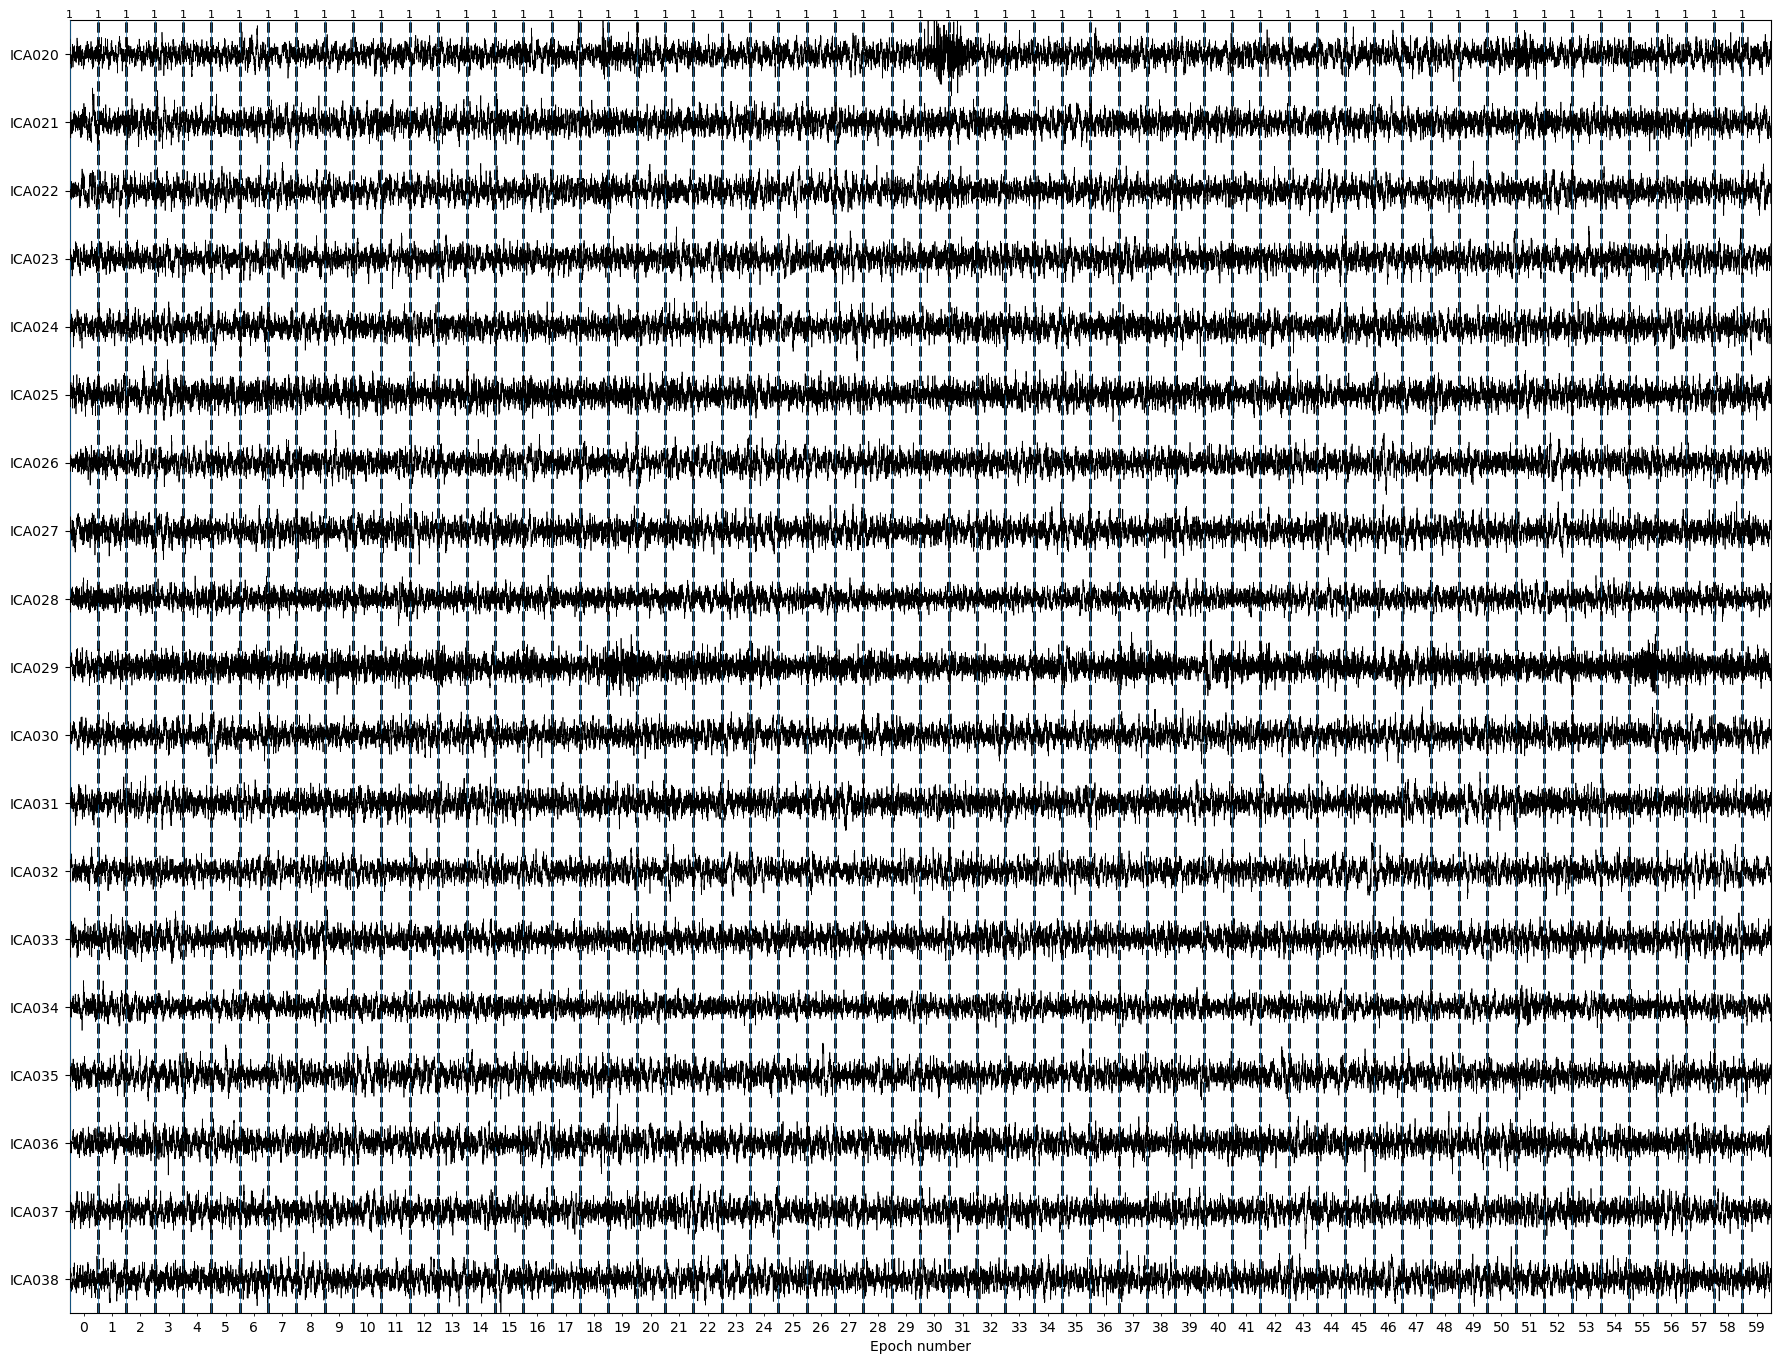

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated


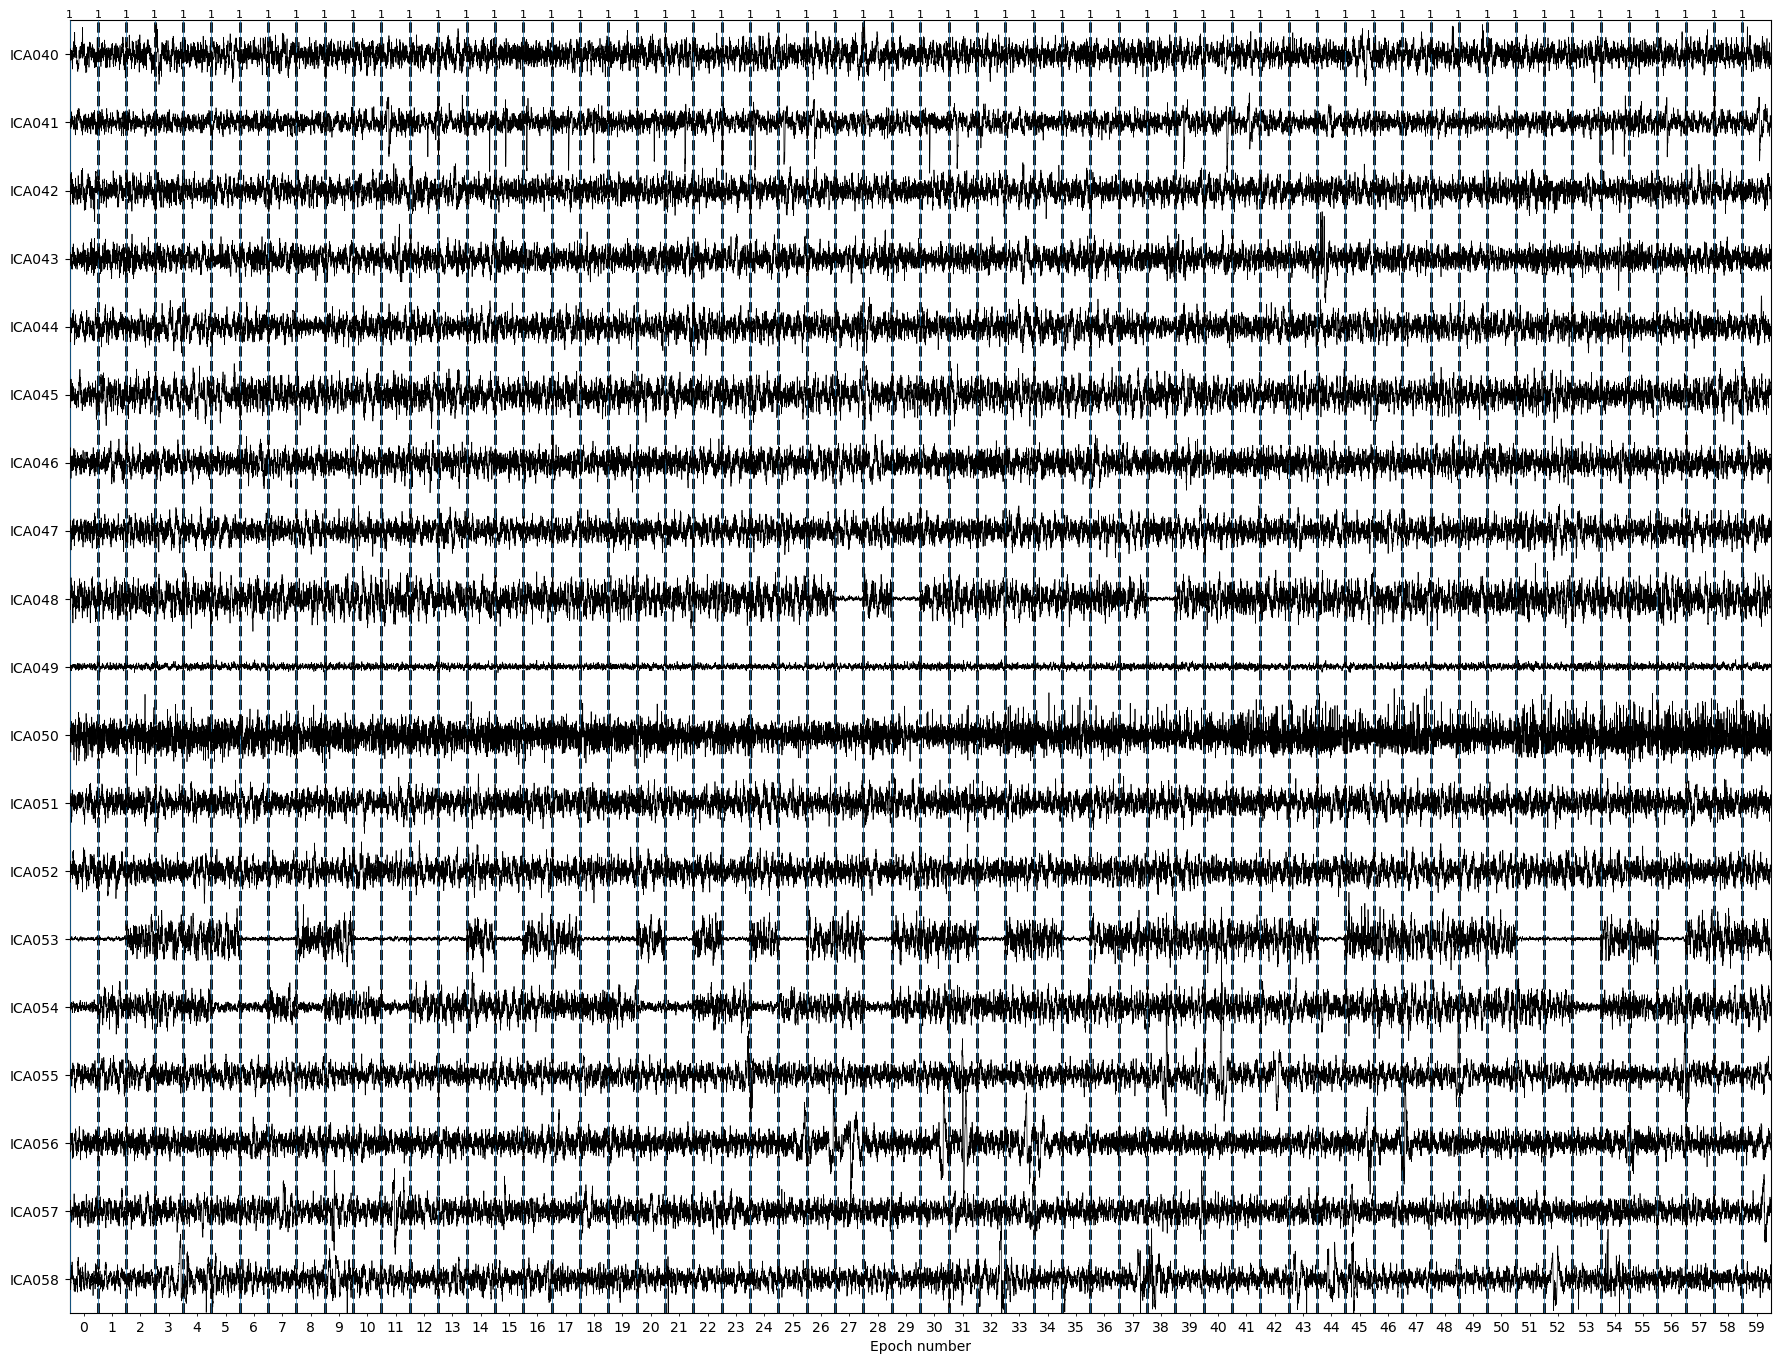

In [23]:
_ = ica.plot_sources(
    epochs_ar, show_scrollbars=False, start=0, stop=60, picks=slice(0, 19)
)
_ = ica.plot_sources(
    epochs_ar, show_scrollbars=False, start=0, stop=60, picks=slice(20, 39)
)
_ = ica.plot_sources(
    epochs_ar, show_scrollbars=False, start=0, stop=60, picks=slice(40, 59)
)